<h2>Initializing</h2>
<p>Import Libraries, add variables for attribute strings (to save '') and load data</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix 
from sklearn import tree
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.utils.multiclass import unique_labels

fixed_acidity = 'fixed acidity'
volatile_acidity = 'volatile acidity'
citric_acid = 'citric acid'
residual_sugar = 'residual sugar'
chlorides = 'chlorides'
free_sulfur_dioxide = 'free sulfur dioxide'
total_sulfur_dioxide = 'total sulfur dioxide'
density = 'density'
ph = 'pH'
sulphates = 'sulphates'
alcohol = 'alcohol'
quality = 'quality'
qclass = 'qclass'
ratio_to_fixed = 'ratio_to_fixed'
ratio_to_volatile = 'ratio_to_volatile'
ph_acidity = 'ph_acidity'
ratio_to_ph = 'ratio_to_ph'

In [2]:
def confusion_matrix_report(y_true, y_pred):
    cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
    column_width = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
    report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
    for i, label1 in enumerate(labels):
        report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
    return report

<p>Import red and white dataset.<br/>
Split into input matrix (independent vars) and output vector (target vars).<br/>
</p>

<p>sort for kNN (https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-nearest-neighbors) </p>

In [3]:
white = pd.read_csv("data/winequality-white1.csv")
red = pd.read_csv("data/winequality-red1.csv")
white.sort_values(by='quality',inplace=True)
red.sort_values(by='quality',inplace=True)
white_target = white[quality]
red_target = red[quality]
white_input = white.drop(quality,axis=1)
red_input = red.drop(quality,axis=1)

Add ratio of acidity to sugar as attribute.

In [4]:
#white[ph_acidity] = 7 - white[ph]
#red[ph_acidity] = 7 - red[ph]
#white_input[ratio_to_fixed]=white[residual_sugar]/white[fixed_acidity]
#white_input[ratio_to_volatile]=white[residual_sugar]/white[volatile_acidity]
#white_input[ratio_to_ph]=white[residual_sugar]/white[ph_acidity]
#red_input[ratio_to_fixed]=red[residual_sugar]/red[fixed_acidity]
#red_input[ratio_to_volatile]=red[residual_sugar]/red[volatile_acidity]
#red_input[ratio_to_ph]=red[residual_sugar]/red[ph_acidity]

<p>using log.</p>

In [5]:
log_white_norm=np.log(white_input+1)
log_red_norm=np.log(red_input+1)

<p>Normalize using MinMax Normalizer.</p>

In [6]:
mm_white_norm=(white_input-white_input.min())/(white_input.max()-white_input.min())
mm_red_norm=(red_input-red_input.min())/(red_input.max()-red_input.min())

<p>Normalize using Mean Normalizer.</p>

In [7]:
white_norm=(white_input-white_input.mean())/(white_input.std())
red_norm=(red_input-red_input.mean())/(red_input.std())

<p>Correlation Matrices</p>

In [8]:
wcorr = white.corr()
wcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.0227,0.289,0.089,0.0231,-0.0494,0.0911,0.265,-0.426,-0.0171,-0.121,-0.114
volatile acidity,-0.0227,1,-0.149,0.0643,0.0705,-0.097,0.0893,0.0271,-0.0319,-0.0357,0.0677,-0.195
citric acid,0.289,-0.149,1,0.0942,0.114,0.0941,0.121,0.15,-0.164,0.0623,-0.0757,-0.00921
residual sugar,0.089,0.0643,0.0942,1,0.0887,0.299,0.401,0.839,-0.194,-0.0267,-0.451,-0.0976
chlorides,0.0231,0.0705,0.114,0.0887,1,0.101,0.199,0.257,-0.0904,0.0168,-0.36,-0.21
free sulfur dioxide,-0.0494,-0.097,0.0941,0.299,0.101,1,0.616,0.294,-0.000618,0.0592,-0.25,0.00816
total sulfur dioxide,0.0911,0.0893,0.121,0.401,0.199,0.616,1,0.53,0.00232,0.135,-0.449,-0.175
density,0.265,0.0271,0.15,0.839,0.257,0.294,0.53,1,-0.0936,0.0745,-0.78,-0.307
pH,-0.426,-0.0319,-0.164,-0.194,-0.0904,-0.000618,0.00232,-0.0936,1,0.156,0.121,0.0994
sulphates,-0.0171,-0.0357,0.0623,-0.0267,0.0168,0.0592,0.135,0.0745,0.156,1,-0.0174,0.0537


In [9]:
rcorr = red.corr()
rcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.256,0.672,0.115,0.0937,-0.154,-0.113,0.668,-0.683,0.183,-0.0617,0.124
volatile acidity,-0.256,1,-0.552,0.00192,0.0613,-0.0105,0.0765,0.022,0.235,-0.261,-0.202,-0.391
citric acid,0.672,-0.552,1,0.144,0.204,-0.061,0.0355,0.365,-0.542,0.313,0.11,0.226
residual sugar,0.115,0.00192,0.144,1,0.0556,0.187,0.203,0.355,-0.0857,0.00553,0.0421,0.0137
chlorides,0.0937,0.0613,0.204,0.0556,1,0.00556,0.0474,0.201,-0.265,0.371,-0.221,-0.129
free sulfur dioxide,-0.154,-0.0105,-0.061,0.187,0.00556,1,0.668,-0.0219,0.0704,0.0517,-0.0694,-0.0507
total sulfur dioxide,-0.113,0.0765,0.0355,0.203,0.0474,0.668,1,0.0713,-0.0665,0.0429,-0.206,-0.185
density,0.668,0.022,0.365,0.355,0.201,-0.0219,0.0713,1,-0.342,0.149,-0.496,-0.175
pH,-0.683,0.235,-0.542,-0.0857,-0.265,0.0704,-0.0665,-0.342,1,-0.197,0.206,-0.0577
sulphates,0.183,-0.261,0.313,0.00553,0.371,0.0517,0.0429,0.149,-0.197,1,0.0936,0.251


<h2>Assigning classes</h2>
<p>
    Assign classes based on quality. Less than 6; 6; better than 6. Because it makes sense considering the distribution of ratings.
</p>

In [10]:
conditions = [(white['quality'] < 6),
              (white['quality'] > 6)]
choices = ['2_low', '1_high']
white['class'] = np.select(conditions, choices, default = '3_medium')

conditions = [(red['quality'] < 6),
              (red['quality'] > 6)]
choices = ['3_low', '1_high']
red['class'] = np.select(conditions, choices, default = '2_medium')

print('class distribution fot white:')
print(white['class'].value_counts())
print('\n class distribution for red:')
print(red['class'].value_counts())

white_norm['class']=white['class']
red_norm['class']=red['class']
white_targetclass = white['class']
red_targetclass = red['class']

class distribution fot white:
3_medium    2198
2_low       1640
1_high      1060
Name: class, dtype: int64

 class distribution for red:
3_low       744
2_medium    638
1_high      217
Name: class, dtype: int64


In [11]:
white_norm_input = white_norm.drop('class', axis = 1)
red_norm_input = red_norm.drop('class', axis = 1)

In [12]:
#white_norm.loc[white_norm['class']=='3_high'].describe()
#white_norm.loc[white_norm['class']=='2_medium'].describe()
#white_norm.loc[white_norm['class']=='1_low'].describe()
white_norm_filtered = white_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
white_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol
count,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03
mean,-8.565083e-15,-1.998539e-14,6.443990e-14,-6.380722e-17,-2.226113e-16,1.628816e-12,-4.325046e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.619982e+00,-1.966784e+00,-2.761461e+00,-1.958477e+00,-3.043919e+00,-2.312802e+00,-2.043089e+00
25%,-6.574340e-01,-6.770318e-01,-5.304215e-01,-7.237012e-01,-7.144009e-01,-7.706280e-01,-8.241915e-01
50%,-6.492444e-02,-1.809733e-01,-1.172660e-01,-7.691388e-02,-1.026084e-01,-9.608339e-02,-9.285319e-02
75%,5.275851e-01,4.142970e-01,4.611517e-01,6.286722e-01,6.738976e-01,6.929749e-01,7.197450e-01
max,8.704217e+00,8.152811e+00,1.095530e+01,1.491679e+01,7.097720e+00,1.502976e+01,2.995020e+00


In [13]:
#red_norm.loc[red_norm['class']=='3_high'].describe()
#red_norm.loc[red_norm['class']=='2_medium'].describe()
#red_norm.loc[red_norm['class']=='1_low'].describe()
red_norm_filtered = red_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
red_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,1.264661e-14,8.477896e-15,-2.005813e-15,-1.055285e-16,2.365560e-16,1.317714e-12,2.204136e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-1.898325e+00
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-8.661079e-01
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-1.792441e-01,-2.574163e-01,1.759533e-03,-2.092427e-01
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.899619e-01,4.721707e-01,5.766445e-01,6.352984e-01
max,4.353787e+00,5.876138e+00,3.742403e+00,5.365606e+00,7.372847e+00,3.678904e+00,4.201138e+00


<h2>k-NN classification<h2><p>https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#the-curse-of-dimensionality</p>

<h3>white: normalized and selected for attributes with low std/range</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     718       54      288
   2_low      67     1140      433
3_medium     290      406     1502

             precision    recall  f1-score   support

     1_high       0.67      0.68      0.67      1060
      2_low       0.71      0.70      0.70      1640
   3_medium       0.68      0.68      0.68      2198

avg / total       0.69      0.69      0.69      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     811       83      166
   2_low     164     1250      226
3_medium     570      675      953

             precision    recall  f1-score   support

     1_high       0.52      0.77      0.62      1060
      2_low       0.62      0.76      0.69      1640
   3_medium       0.71      0.43      0.54      2198

avg / total       0.64      0.62      0.61      4898

3 neighbours:
3 neighbours//
         _______Prediction_

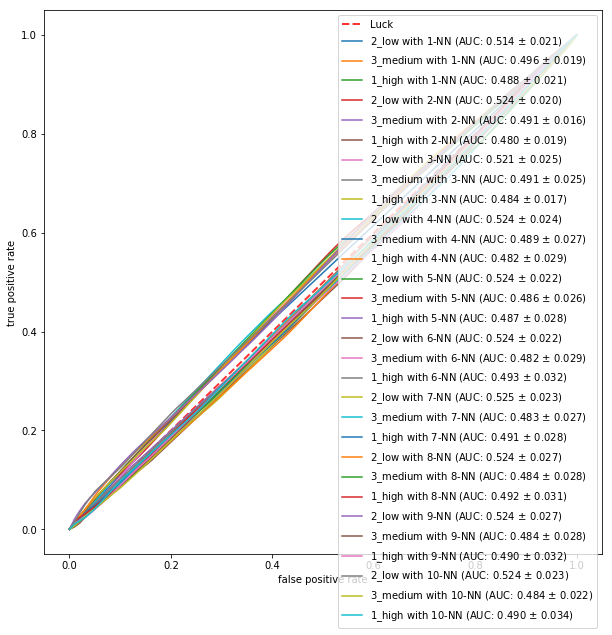

In [14]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data) 
        #print(classification_report(test_target, estimator.predict(test_data)))
        
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

def run_knn_report(inputs, targets):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
    for n_neighbour in range(1,11):
        print(str(n_neighbour) + " neighbours:")
        knn_estimator = KNeighborsClassifier(n_neighbour)
        for classlabel in targets.unique():
            mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator, inputs, targets,classlabel)
            plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
        predicted = cross_val_predict(knn_estimator,inputs,targets,cv=cv)
        print(confusion_matrix_report(targets,predicted))
        print(classification_report(targets,predicted))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()
    
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
#cv = KFold(n_splits=3)
run_knn_report(white_norm_filtered.values, white_targetclass)


<h3><i>red: </i>normalized and selected for attributes with low std/range</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     133       63       21
2_medium      76      401      161
   3_low      29      163      552

             precision    recall  f1-score   support

     1_high       0.56      0.61      0.58       217
   2_medium       0.64      0.63      0.63       638
      3_low       0.75      0.74      0.75       744

avg / total       0.68      0.68      0.68      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     157       48       12
2_medium     148      395       95
   3_low      56      288      400

             precision    recall  f1-score   support

     1_high       0.43      0.72      0.54       217
   2_medium       0.54      0.62      0.58       638
      3_low       0.79      0.54      0.64       744

avg / total       0.64      0.60      0.60      1599

3 neighbours:
3 neighbours//
         _______Prediction_

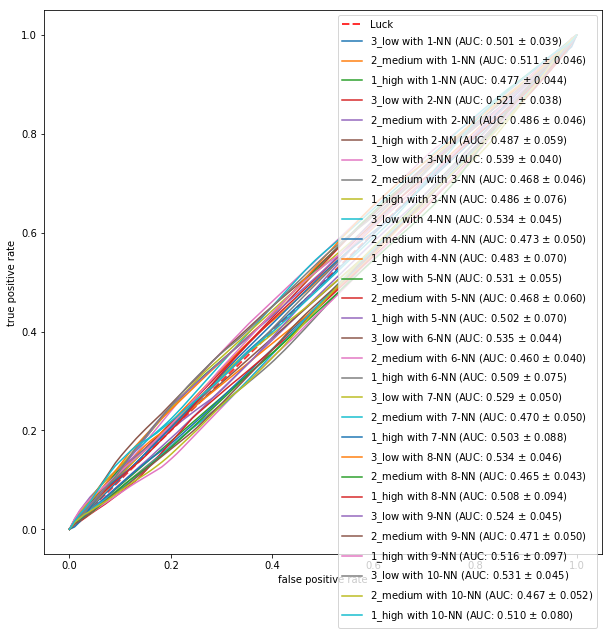

In [15]:
run_knn_report(red_norm_filtered.values,red_targetclass)

<h3>white: normalized unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     725       59      276
   2_low      68     1156      416
3_medium     279      381     1538

             precision    recall  f1-score   support

     1_high       0.68      0.68      0.68      1060
      2_low       0.72      0.70      0.71      1640
   3_medium       0.69      0.70      0.69      2198

avg / total       0.70      0.70      0.70      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     831       71      158
   2_low     155     1244      241
3_medium     549      661      988

             precision    recall  f1-score   support

     1_high       0.54      0.78      0.64      1060
      2_low       0.63      0.76      0.69      1640
   3_medium       0.71      0.45      0.55      2198

avg / total       0.65      0.63      0.62      4898

3 neighbours:
3 neighbours//
         _______Prediction_

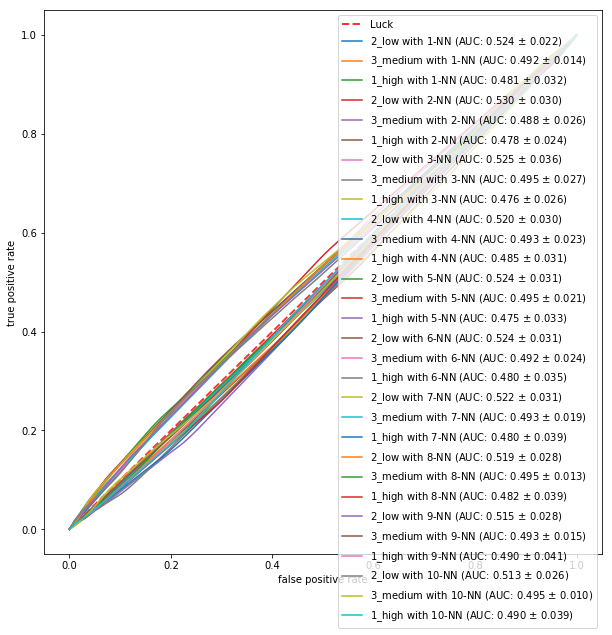

In [16]:
run_knn_report(white_norm_input.values,white_targetclass)

<h3><i>red: </i> normalized unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     135       61       21
2_medium      68      412      158
   3_low      24      166      554

             precision    recall  f1-score   support

     1_high       0.59      0.62      0.61       217
   2_medium       0.64      0.65      0.65       638
      3_low       0.76      0.74      0.75       744

avg / total       0.69      0.69      0.69      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     166       44        7
2_medium     141      414       83
   3_low      45      283      416

             precision    recall  f1-score   support

     1_high       0.47      0.76      0.58       217
   2_medium       0.56      0.65      0.60       638
      3_low       0.82      0.56      0.67       744

avg / total       0.67      0.62      0.63      1599

3 neighbours:
3 neighbours//
         _______Prediction_

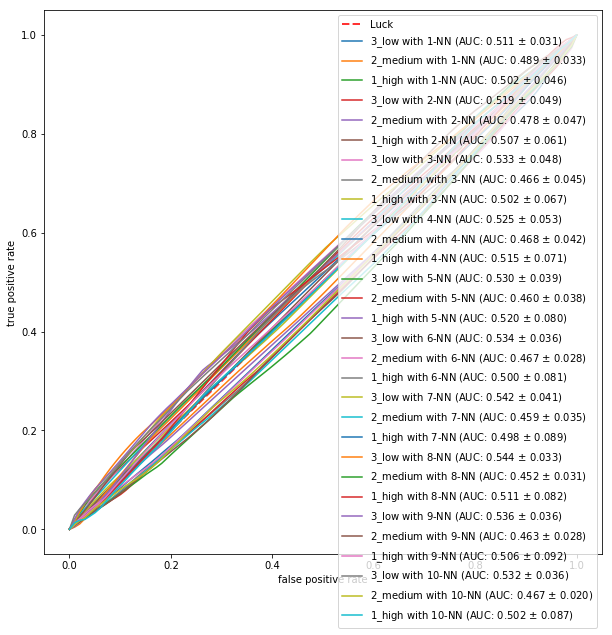

In [17]:
run_knn_report(red_norm_input.values,red_targetclass)

<h3> white: unfiltered, unnormalized <h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     628      107      325
   2_low     138     1052      450
3_medium     326      437     1435

             precision    recall  f1-score   support

     1_high       0.58      0.59      0.58      1060
      2_low       0.66      0.64      0.65      1640
   3_medium       0.65      0.65      0.65      2198

avg / total       0.64      0.64      0.64      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     738      138      184
   2_low     275     1110      255
3_medium     607      750      841

             precision    recall  f1-score   support

     1_high       0.46      0.70      0.55      1060
      2_low       0.56      0.68      0.61      1640
   3_medium       0.66      0.38      0.48      2198

avg / total       0.58      0.55      0.54      4898

3 neighbours:
3 neighbours//
         _______Prediction_

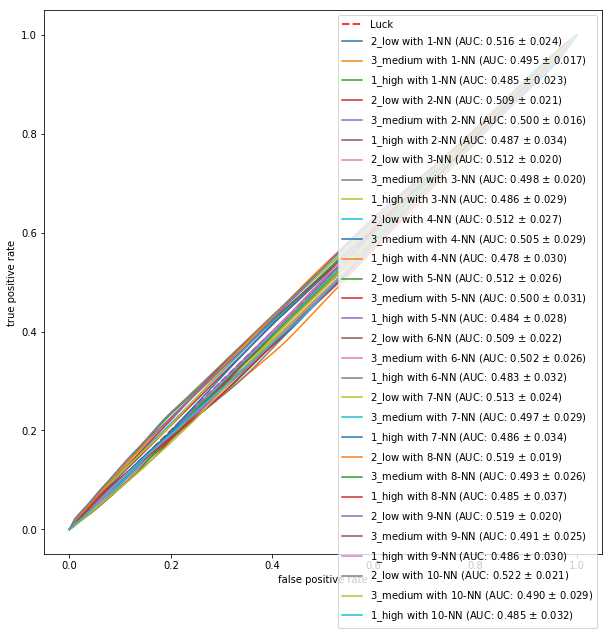

In [18]:
run_knn_report(white_input.values,white_targetclass)

<h3>red, unnormalized, unselected</h3>

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     114       75       28
2_medium      59      398      181
   3_low      38      188      518

             precision    recall  f1-score   support

     1_high       0.54      0.53      0.53       217
   2_medium       0.60      0.62      0.61       638
      3_low       0.71      0.70      0.70       744

avg / total       0.65      0.64      0.64      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     136       66       15
2_medium     115      412      111
   3_low      73      306      365

             precision    recall  f1-score   support

     1_high       0.42      0.63      0.50       217
   2_medium       0.53      0.65      0.58       638
      3_low       0.74      0.49      0.59       744

avg / total       0.61      0.57      0.57      1599

3 neighbours:
3 neighbours//
         _______Prediction_

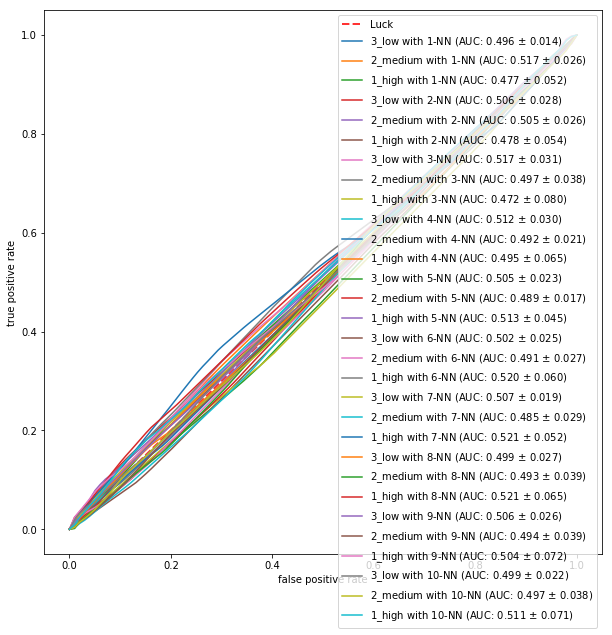

In [19]:
run_knn_report(red_input.values,red_targetclass)

In [20]:
def run_knc_report(inputs, targets):
    knc_estimator = NearestCentroid()
    predicted = cross_val_predict(knc_estimator,inputs,targets,cv=cv)
    print(confusion_matrix_report(targets,predicted))
    print(classification_report(targets,predicted))

In [21]:
run_knc_report(white_norm_input.values,white_targetclass)

         _______Prediction_______
          1_high    2_low 3_medium
  1_high     740      139      181
   2_low     293     1081      266
3_medium     876      785      537

             precision    recall  f1-score   support

     1_high       0.39      0.70      0.50      1060
      2_low       0.54      0.66      0.59      1640
   3_medium       0.55      0.24      0.34      2198

avg / total       0.51      0.48      0.46      4898



In [22]:
run_knc_report(red_norm_input.values,red_targetclass)

         _______Prediction_______
          1_high 2_medium    3_low
  1_high     163       43       11
2_medium     201      220      217
   3_low      58      145      541

             precision    recall  f1-score   support

     1_high       0.39      0.75      0.51       217
   2_medium       0.54      0.34      0.42       638
      3_low       0.70      0.73      0.72       744

avg / total       0.59      0.58      0.57      1599



In [23]:
def run_kncs_report(inputs, targets,thresh=0):
    knc_estimator = NearestCentroid(shrink_threshold=thresh)
    predicted = cross_val_predict(knc_estimator,inputs,targets,cv=cv)
    print(confusion_matrix_report(targets,predicted))
    print(classification_report(targets,predicted))

In [24]:
run_kncs_report(white_norm_input.values,white_targetclass)

         _______Prediction_______
          1_high    2_low 3_medium
  1_high     740      139      181
   2_low     293     1081      266
3_medium     876      785      537

             precision    recall  f1-score   support

     1_high       0.39      0.70      0.50      1060
      2_low       0.54      0.66      0.59      1640
   3_medium       0.55      0.24      0.34      2198

avg / total       0.51      0.48      0.46      4898



In [25]:
for t in range (0,1000,100):
    t = t/100000
    print(t)
    run_kncs_report(white_norm_input.values,white_targetclass,t)

0.0
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     740      139      181
   2_low     293     1081      266
3_medium     876      785      537

             precision    recall  f1-score   support

     1_high       0.39      0.70      0.50      1060
      2_low       0.54      0.66      0.59      1640
   3_medium       0.55      0.24      0.34      2198

avg / total       0.51      0.48      0.46      4898

0.001
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     740      139      181
   2_low     293     1081      266
3_medium     876      785      537

             precision    recall  f1-score   support

     1_high       0.39      0.70      0.50      1060
      2_low       0.54      0.66      0.59      1640
   3_medium       0.55      0.24      0.34      2198

avg / total       0.51      0.48      0.46      4898

0.002
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     740      139    

In [26]:
print(white_norm_input.describe())

       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   4.898000e+03      4.898000e+03  4.898000e+03    4.898000e+03   
mean   -8.565083e-15     -1.998539e-14  6.443990e-14    1.256968e-15   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -3.619982e+00     -1.966784e+00 -2.761461e+00   -1.141827e+00   
25%    -6.574340e-01     -6.770318e-01 -5.304215e-01   -9.249530e-01   
50%    -6.492444e-02     -1.809733e-01 -1.172660e-01   -2.348977e-01   
75%     5.275851e-01      4.142970e-01  4.611517e-01    6.917479e-01   
max     8.704217e+00      8.152811e+00  1.095530e+01    1.171292e+01   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  4.898000e+03         4.898000e+03          4.898000e+03  4.898000e+03   
mean   2.245493e-15        -6.380722e-17         -2.226113e-16  1.628816e-12   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.683102e+00        -1.9

In [27]:
print(red_targetclass)

1478     3_low
832      3_low
899      3_low
1374     3_low
459      3_low
517      3_low
1469     3_low
690      3_low
1505     3_low
1299     3_low
724      3_low
647      3_low
151      3_low
1293     3_low
927      3_low
261      3_low
45       3_low
266      3_low
937      3_low
1261     3_low
833      3_low
633      3_low
1124     3_low
1276     3_low
1480     3_low
170      3_low
73       3_low
161      3_low
1307     3_low
167      3_low
         ...  
896     1_high
339     1_high
1125    1_high
1201    1_high
335     1_high
492     1_high
334     1_high
1452    1_high
898     1_high
1451    1_high
901     1_high
1450    1_high
1269    1_high
588     1_high
498     1_high
1061    1_high
278     1_high
440     1_high
828     1_high
455     1_high
481     1_high
1202    1_high
267     1_high
1120    1_high
390     1_high
495     1_high
1403    1_high
1090    1_high
1449    1_high
1549    1_high
Name: class, Length: 1599, dtype: object


In [28]:
def run_knnw_report(inputs, targets):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
    for n_neighbour in range(1,11):
        print(str(n_neighbour) + " neighbours:")
        knn_estimator = KNeighborsClassifier(n_neighbour,weights='distance')
        for classlabel in targets.unique():
            mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator, inputs, targets,classlabel)
            plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
        predicted = cross_val_predict(knn_estimator,inputs,targets,cv=cv)
        print(confusion_matrix_report(targets,predicted))
        print(classification_report(targets,predicted))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     725       59      276
   2_low      68     1156      416
3_medium     279      381     1538

             precision    recall  f1-score   support

     1_high       0.68      0.68      0.68      1060
      2_low       0.72      0.70      0.71      1640
   3_medium       0.69      0.70      0.69      2198

avg / total       0.70      0.70      0.70      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     725       59      276
   2_low      68     1156      416
3_medium     279      381     1538

             precision    recall  f1-score   support

     1_high       0.68      0.68      0.68      1060
      2_low       0.72      0.70      0.71      1640
   3_medium       0.69      0.70      0.69      2198

avg / total       0.70      0.70      0.70      4898

3 neighbours:
3 neighbours//
         _______Prediction_

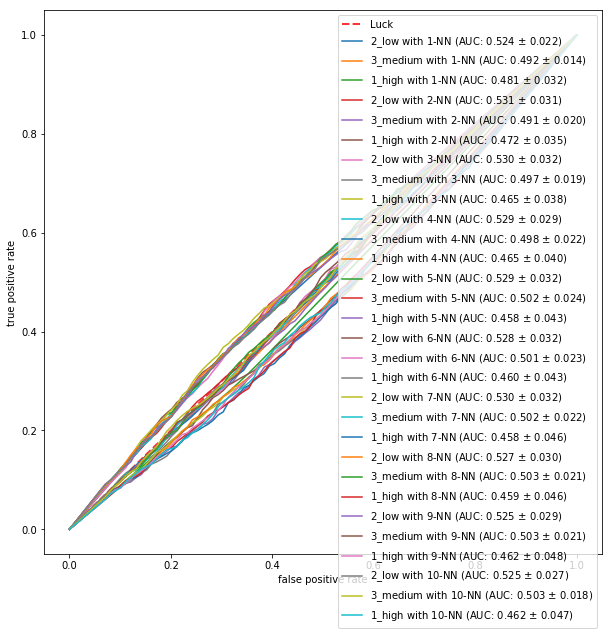

In [29]:
run_knnw_report(white_norm_input.values,white_targetclass)

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     135       61       21
2_medium      68      412      158
   3_low      24      166      554

             precision    recall  f1-score   support

     1_high       0.59      0.62      0.61       217
   2_medium       0.64      0.65      0.65       638
      3_low       0.76      0.74      0.75       744

avg / total       0.69      0.69      0.69      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     135       61       21
2_medium      68      412      158
   3_low      24      166      554

             precision    recall  f1-score   support

     1_high       0.59      0.62      0.61       217
   2_medium       0.64      0.65      0.65       638
      3_low       0.76      0.74      0.75       744

avg / total       0.69      0.69      0.69      1599

3 neighbours:
3 neighbours//
         _______Prediction_

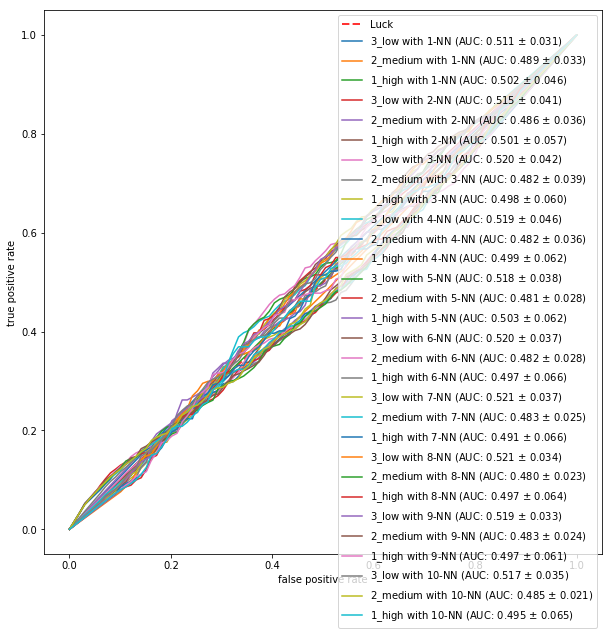

In [30]:
run_knnw_report(red_norm_input.values,red_targetclass)

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     689       67      304
   2_low      89     1139      412
3_medium     318      416     1464

             precision    recall  f1-score   support

     1_high       0.63      0.65      0.64      1060
      2_low       0.70      0.69      0.70      1640
   3_medium       0.67      0.67      0.67      2198

avg / total       0.67      0.67      0.67      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     689       67      304
   2_low      89     1139      412
3_medium     318      416     1464

             precision    recall  f1-score   support

     1_high       0.63      0.65      0.64      1060
      2_low       0.70      0.69      0.70      1640
   3_medium       0.67      0.67      0.67      2198

avg / total       0.67      0.67      0.67      4898

3 neighbours:
3 neighbours//
         _______Prediction_

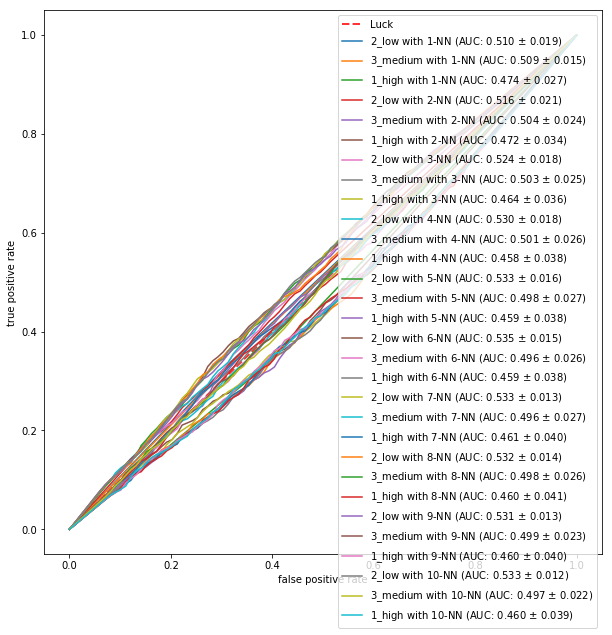

In [33]:
run_knnw_report(log_white_norm.values,white_targetclass)

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     132       70       15
2_medium      75      395      168
   3_low      23      163      558

             precision    recall  f1-score   support

     1_high       0.57      0.61      0.59       217
   2_medium       0.63      0.62      0.62       638
      3_low       0.75      0.75      0.75       744

avg / total       0.68      0.68      0.68      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     132       70       15
2_medium      75      395      168
   3_low      23      163      558

             precision    recall  f1-score   support

     1_high       0.57      0.61      0.59       217
   2_medium       0.63      0.62      0.62       638
      3_low       0.75      0.75      0.75       744

avg / total       0.68      0.68      0.68      1599

3 neighbours:
3 neighbours//
         _______Prediction_

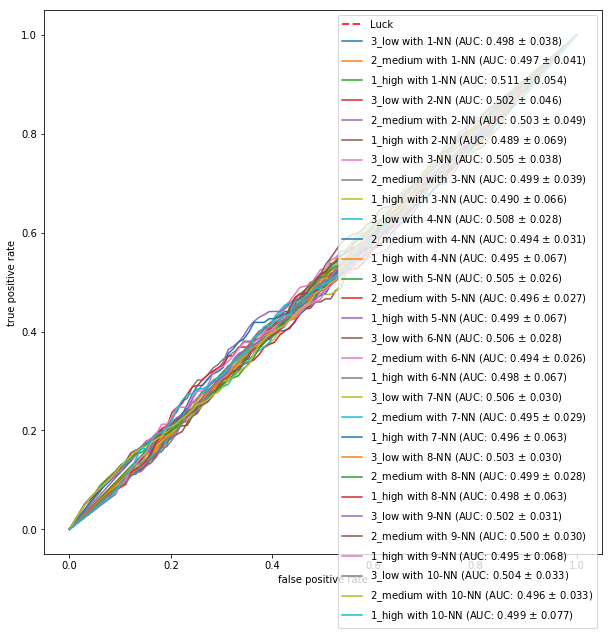

In [34]:
run_knnw_report(log_red_norm.values,red_targetclass)

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     723       60      277
   2_low      69     1163      408
3_medium     295      375     1528

             precision    recall  f1-score   support

     1_high       0.67      0.68      0.67      1060
      2_low       0.73      0.71      0.72      1640
   3_medium       0.69      0.70      0.69      2198

avg / total       0.70      0.70      0.70      4898

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high    2_low 3_medium
  1_high     723       60      277
   2_low      69     1163      408
3_medium     295      375     1528

             precision    recall  f1-score   support

     1_high       0.67      0.68      0.67      1060
      2_low       0.73      0.71      0.72      1640
   3_medium       0.69      0.70      0.69      2198

avg / total       0.70      0.70      0.70      4898

3 neighbours:
3 neighbours//
         _______Prediction_

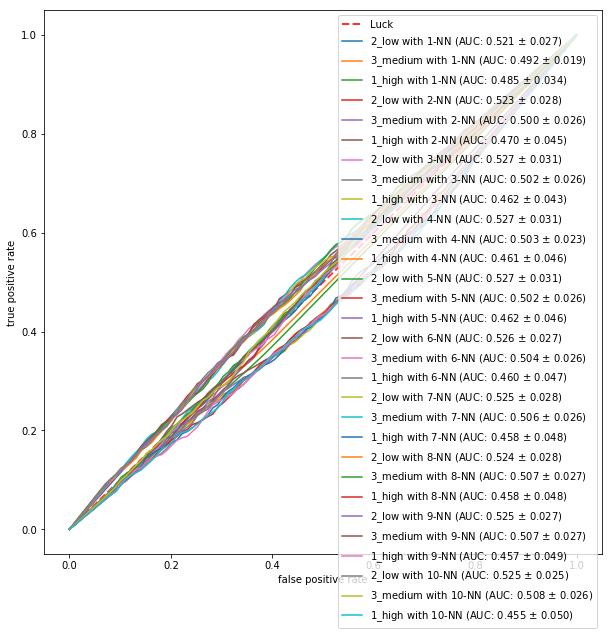

In [35]:
run_knnw_report(mm_white_norm.values,white_targetclass)

1 neighbours:
1 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     130       66       21
2_medium      67      416      155
   3_low      24      167      553

             precision    recall  f1-score   support

     1_high       0.59      0.60      0.59       217
   2_medium       0.64      0.65      0.65       638
      3_low       0.76      0.74      0.75       744

avg / total       0.69      0.69      0.69      1599

2 neighbours:
2 neighbours//
         _______Prediction_______
          1_high 2_medium    3_low
  1_high     130       66       21
2_medium      67      416      155
   3_low      24      167      553

             precision    recall  f1-score   support

     1_high       0.59      0.60      0.59       217
   2_medium       0.64      0.65      0.65       638
      3_low       0.76      0.74      0.75       744

avg / total       0.69      0.69      0.69      1599

3 neighbours:
3 neighbours//
         _______Prediction_

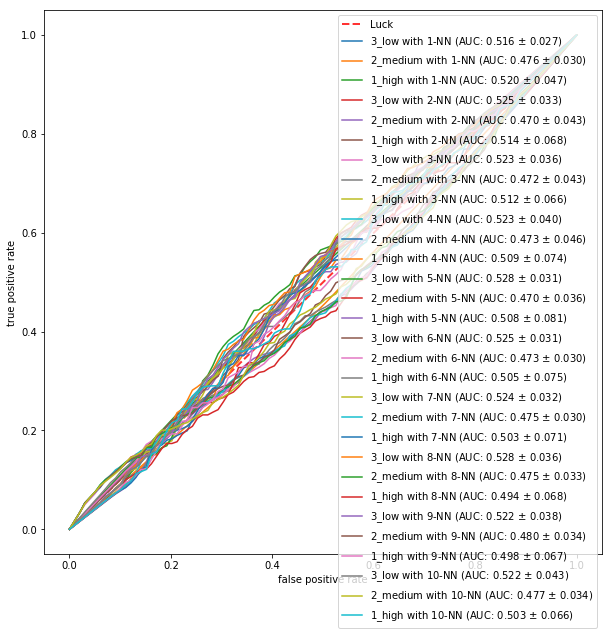

In [37]:
run_knnw_report(mm_red_norm.values,red_targetclass)